# Домашнее задание: LARS и варианты реализации многоклассовой классификации

## Задание 1: Реализация регрессии с наименьшими углами (LARS)
Регрессия с наименьшими углами (LARS) — это алгоритм регрессии, который выбирает признаки пошагово, что делает его подходящим для задач с большим количеством признаков. Цель — найти подмножество признаков, которые наилучшим образом объясняют целевую переменную.

- LARS начинается с нуля для всех коэффициентов.

- Алгоритм находит признак, наиболее коррелирующий с откликом, и обновляет коэффициент этого признака до его значения по методу наименьших квадратов, пока не будут включены все признаки или не выполнено условие остановки.

Тут можно прочитать подробнее про алгоритм работы https://www.geeksforgeeks.org/least-angle-regression-lars/

In [ ]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Lars

class LARS:
    def __init__(self, max_iter=None):
        self.max_iter = max_iter
        
    def fit(self, X, y):
        n_samples, n_features = X.shape

        X = X.copy()
        self.X_mean_ = np.mean(X, axis=0)
        self.X_std_ = np.std(X, axis=0)
        X = (X - self.X_mean_) / (self.X_std_ + 1e-8)
        
        self.y_mean_ = np.mean(y)
        y_centered = y - self.y_mean_
        
        self.coefs_ = np.zeros(n_features)
        active = []
        residuals = y_centered.copy()
        
        max_iterations = self.max_iter if self.max_iter else min(n_samples, n_features)
        
        for iteration in range(max_iterations):
            corr = np.abs(X.T @ residuals)
            
            for idx in active:
                corr[idx] = 0
                
            if np.max(corr) < 1e-10:
                break
                
            max_corr_idx = np.argmax(corr)
            active.append(max_corr_idx)
            
            X_active = X[:, active]

            try:
                G = X_active.T @ X_active
                G_inv = np.linalg.inv(G)
                
                ones = np.ones(len(active))
                n_const = 1.0 / np.sqrt(ones.T @ G_inv @ ones)
                w = n_const * G_inv @ ones
                u = X_active @ w
                
                a = X.T @ u
                
                gamma_vals = []
                
                C = np.max(np.abs(X.T @ residuals))
                for j in range(n_features):
                    if j not in active:
                        denom1 = n_const - a[j]
                        denom2 = n_const + a[j]
                        
                        if denom1 > 1e-10:
                            gamma_vals.append(C / denom1)
                        if denom2 > 1e-10:
                            gamma_vals.append(C / denom2)
                

                current_coefs = np.zeros(len(active))
                if iteration > 0:
                    for i, idx in enumerate(active[:-1]):
                        current_coefs[i] = self.coefs_[idx]
                
                for i, coef in enumerate(current_coefs):
                    if w[i] < -1e-10:
                        gamma_vals.append(-coef / w[i])
                
                if gamma_vals:
                    gamma = min(gamma_vals)
                else:
                    gamma = C / n_const
                    
                for i, idx in enumerate(active):
                    self.coefs_[idx] += gamma * w[i]
                    
                residuals -= gamma * u
                
                if np.sum(residuals**2) < 1e-10:
                    break
                    
            except np.linalg.LinAlgError:
                break
        
        self.coefs_ = self.coefs_ / (self.X_std_ + 1e-8)
        self.intercept_ = self.y_mean_ - np.sum(self.coefs_ * self.X_mean_)
        
        return self
        
    def predict(self, X):
        return X @ self.coefs_ + self.intercept_

X_train = np.array([[1], [2], [3], [4], [5]])
y_train = np.array([2, 3, 5, 7, 11])

model = LARS()
model.fit(X_train, y_train)
preds = model.predict(X_train)



In [3]:

assert preds.shape == (5,), "Предсказания должны соответствовать количеству образцов"
assert r2_score(y_train, preds) > 0.8, "R2 должна быть выше 0.8"

In [4]:
# Сравнение с реализацией из sklearn
sklearn_model = Lars()
sklearn_model.fit(X_train, y_train)
sklearn_preds = sklearn_model.predict(X_train)

assert np.allclose(preds, sklearn_preds, rtol=1e-03), "Предсказания должны совпадать с реализацией sklearn"

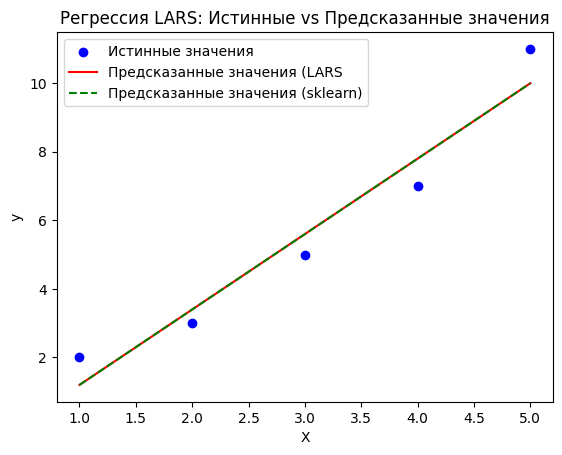

In [5]:
plt.scatter(X_train, y_train, color='blue', label="Истинные значения")
plt.plot(X_train, preds, color='red', label="Предсказанные значения (LARS")
plt.plot(X_train, sklearn_preds, color='green', linestyle='dashed', label="Предсказанные значения (sklearn)")
plt.legend()
plt.title("Регрессия LARS: Истинные vs Предсказанные значения")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Задание 2: Классификация Один-против-Всех и Все-против-Всех с логистической регрессией
В многоклассовой классификации два популярных подхода:

- Один-против-Всех (OvA): Для каждого класса обучается отдельный классификатор, который отделяет этот класс от всех остальных.
- Все-против-Всех (AvA): Обучается классификатор для каждой пары классов.

https://education.yandex.ru/handbook/ml/article/linear-models#:~:text=%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F-,%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F,-%D0%92%20%D1%8D%D1%82%D0%BE%D0%BC%20%D1%80%D0%B0%D0%B7%D0%B4%D0%B5%D0%BB%D0%B5

In [6]:
def plot_ova_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)
    
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')
    
    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("One-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    try:
        plt.show()
    except:
        pass


def plot_ava_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')
    
    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("All-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    # plt.show()
    try:
        plt.show()
    except:
        pass

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
# import seaborn as sns

class OneVsAllClassifier:
    def __init__(self):
        self.models = []
    
    def fit(self, X, y):
        n_classes = len(set(y))
        self.models = []
        
        # TODO: Обучите LogisticRegression для каждого класса
        for class_label in set(y):
            binary_target = (y == class_label).astype(int)
            
            model = LogisticRegression(random_state=42)
            model.fit(X, binary_target)
            
            self.models.append(model)
        
    def predict(self, X):
        pred = np.zeros((X.shape[0], len(self.models)))
        
        # TODO: Рассчитать предсказания для каждой модели
        for i, model in enumerate(self.models):
            pred[:, i] = model.predict_proba(X)[:, 1]
        
        return np.argmax(pred, axis=1)

X_test = np.array([[1, 2], [4, 5], [7, 8], [2, 3], [5, 6]])
y_test = np.array([0, 1, 2, 0, 1])
ova_classifier = OneVsAllClassifier()
ova_classifier.fit(X_test, y_test)
ova_preds = ova_classifier.predict(X_test)

assert len(ova_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ova_preds) > 0.8, "Точность должна быть выше 0.8"

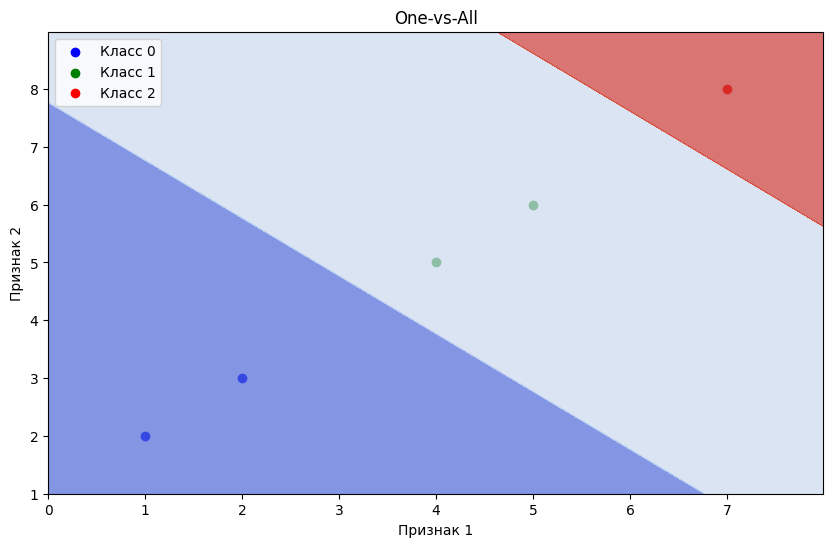

In [8]:
plot_ova_classifier(ova_classifier, X_test, y_test)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
# import seaborn as sns

class AllVsAllClassifier:
    def __init__(self):
        self.pairwise_models = {}
    
    def fit(self, X, y):
        unique_classes = np.unique(y)
        self.pairwise_models = {}
        self.classes = unique_classes
        
        # TODO: Обучите LogisticRegression для каждой пары классов
        for i in range(len(unique_classes)):
            for j in range(i + 1, len(unique_classes)):
                class_i, class_j = unique_classes[i], unique_classes[j]
                
                mask = (y == class_i) | (y == class_j)
                X_pair = X[mask]
                y_pair = y[mask]
                
                model = LogisticRegression(random_state=42)
                model.fit(X_pair, y_pair)
                
                self.pairwise_models[(class_i, class_j)] = model
        
    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.classes)))
        
        # TODO: Получить предсказания для каждой парной модели
        for (class_i, class_j), model in self.pairwise_models.items():
            preds = model.predict(X)
            
            for idx, pred in enumerate(preds):
                if pred == class_i:
                    class_idx = np.where(self.classes == class_i)[0][0]
                    votes[idx, class_idx] += 1
                elif pred == class_j:
                    class_idx = np.where(self.classes == class_j)[0][0]
                    votes[idx, class_idx] += 1
        
        predicted_indices = np.argmax(votes, axis=1)
        return self.classes[predicted_indices]

X_test = np.array([[1, 2], [4, 5], [7, 8], [2, 3], [5, 6]])
y_test = np.array([0, 1, 2, 0, 1])

ava_classifier = AllVsAllClassifier()
ava_classifier.fit(X_test, y_test)
ava_preds = ava_classifier.predict(X_test)

assert len(ava_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ava_preds) > 0.8, "Точность должна быть выше 0.8"

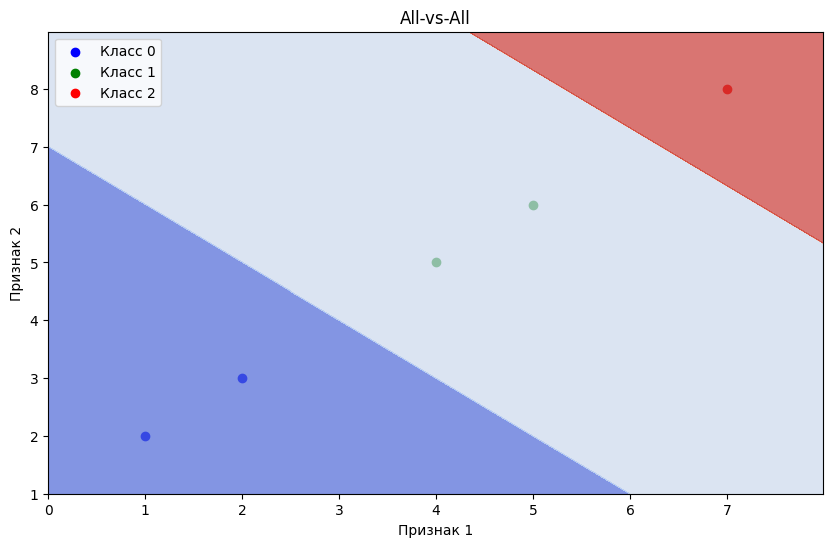

In [10]:
plot_ava_classifier(ava_classifier, X_test, y_test)